In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
import tensorflow as tf
import os
import copy
import sklearn.datasets
import sklearn.model_selection
import sklearn.preprocessing
import Onlinehd

In [2]:
# loads simple mnist dataset
def load():
    # fetches data
    x, y = sklearn.datasets.fetch_openml('mnist_784', return_X_y=True)
    x = x.astype(np.float)
    y = y.astype(np.int)
    y = np.array(y)

    # split and normalize
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y)
    
    x_origin = x.copy()
    x_test_origin = x_test.copy()
    
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()

    return x, x_test, y, y_test, x_origin, x_test_origin, scaler

In [3]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
x_train, x_test, y_train, y_test, x_origin, x_test_origin, scaler = load()

/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_17940/1496100737.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.astype(np.float)
/var/folders/4_/4812b_4j2_s0smfmxlqdpr600000gn/T/ipykernel_17940/1496100737.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://nu

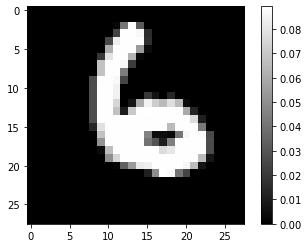

In [5]:
plt.imshow(x_test[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [6]:
print(x_train.shape)
print(y_train.shape)

torch.Size([52500, 784])
torch.Size([52500])


In [7]:
from time import time

classes = y_train.unique().size(0)
features = x_train.size(1)
model = Onlinehd.OnlineHD(classes, features, dim=10000)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    x_test = x_test.cuda()
    y_test = y_test.cuda()
    model = model.to('cuda')
    print('Using GPU!')

print('Training...')
t = time()
model = model.fit(x_train, y_train, bootstrap=1.0, lr=0.035, epochs=20)
t = time() - t

Training...
0
10


In [8]:
print('Validating...')
yhat = model(x_train)
yhat_test = model(x_test)
acc = (y_train == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.945410
acc_test = 0.935429
t = 29.865211


In [27]:
import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

is_cuda = torch.cuda.is_available()

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):  #num_classes; mnist:10/ fmnist:10 / emnist:26

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
   
    image = image
    model = net

    I = torch.argsort(-model.scores(image)).tolist()[0]  # sort image score (descending)
    label = I[0]  #label

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = model.scores(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = image.max().item()
#         pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.cpu().numpy().copy()

            # set new w_k and new f_k

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())
            
            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / (np.linalg.norm(w) + 0.001)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)
        
        x = Variable(pert_image, requires_grad=True)
        fs = model.scores(x)
        k_i = torch.argsort(-fs).tolist()[0][0]  # labels for x

        loop_i += 1

    #r_tot = (1+overshoot)*r_tot

    return pert_image, torch.from_numpy(r_tot.reshape(28, 28)) #loop_i, label, k_i,import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients

def zero_gradients(x):
    if isinstance(x, torch.Tensor):
        if x.grad is not None:
            x.grad.detach_()
            x.grad.zero_()
    elif isinstance(x, collections.abc.Iterable):
        for elem in x:
            zero_gradients(elem)

is_cuda = torch.cuda.is_available()

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=10):  #num_classes; mnist:10/ fmnist:10 / emnist:26

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
   
    image = image
    model = net

    I = torch.argsort(-model.scores(image)).tolist()[0]  # sort image score (descending)
    label = I[0]  #label

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = model.scores(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = image.max().item()
#         pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.cpu().numpy().copy()

            # set new w_k and new f_k

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())
            
            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / (np.linalg.norm(w) + 0.001)
        r_tot = np.float32(r_tot + r_i)*3

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)
        
        x = Variable(pert_image, requires_grad=True)
        fs = model.scores(x)
        k_i = torch.argsort(-fs).tolist()[0][0]  # labels for x

        loop_i += 1

    #r_tot = (1+overshoot)*r_tot

    return pert_image, torch.from_numpy(r_tot.reshape(28, 28)) #loop_i, label, k_i,

In [28]:
x_test_origin = np.array(x_test_origin)

In [29]:
x_test_origin = torch.from_numpy(x_test_origin).float()

In [30]:
X_te_cln = x_test.reshape(-1,1,784)  # x_test
Y_te_cln = y_test #y_test

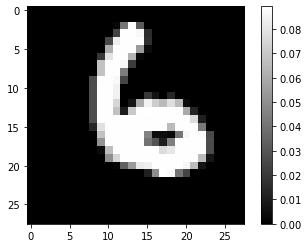

In [31]:
plt.imshow(X_te_cln[-1].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [34]:
from tqdm import tqdm

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(17500, 28, 28)

for i in tqdm(range(17500)):
    x_test_adv[i], x_test_pert[i] = deepfool(X_te_cln[i], model)

100%|███████████████████████████████████| 17500/17500 [1:12:52<00:00,  4.00it/s]


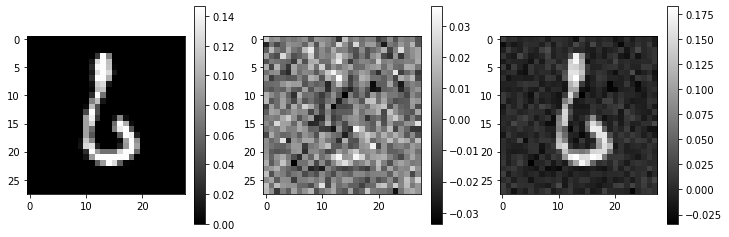

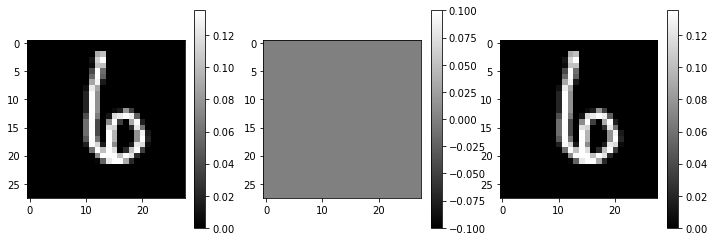

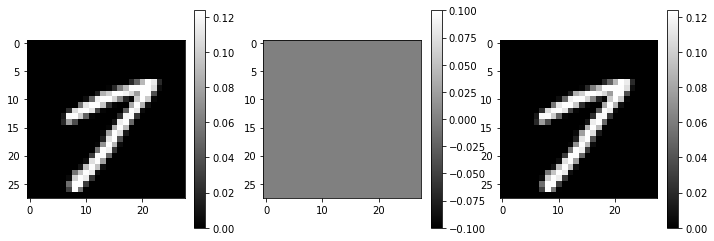

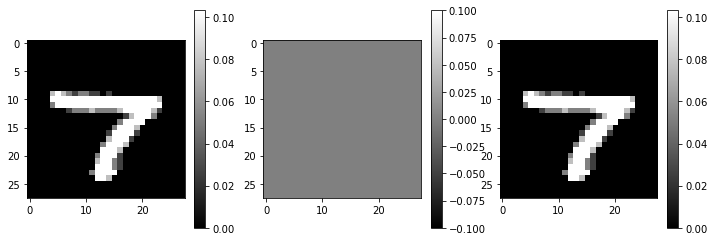

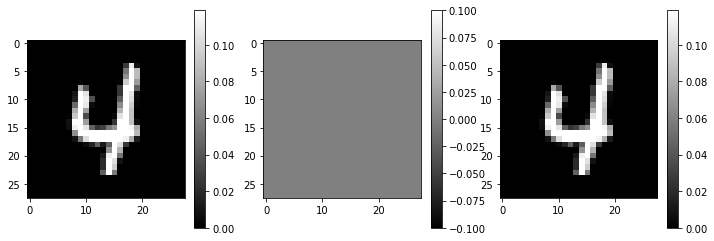

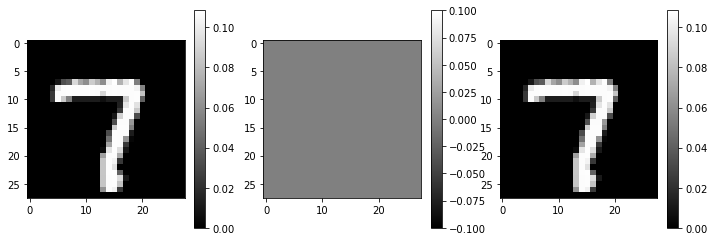

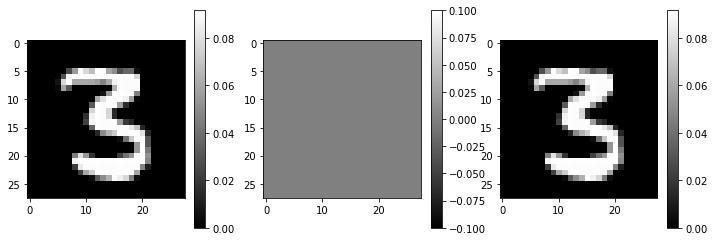

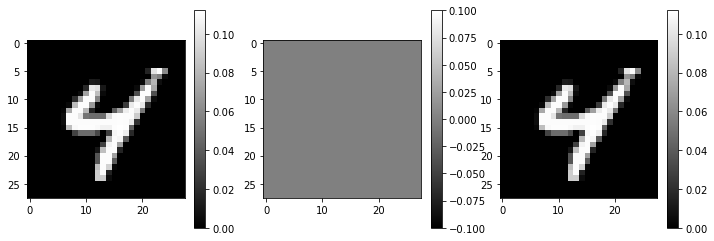

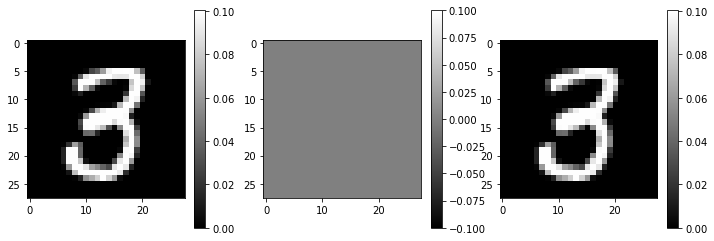

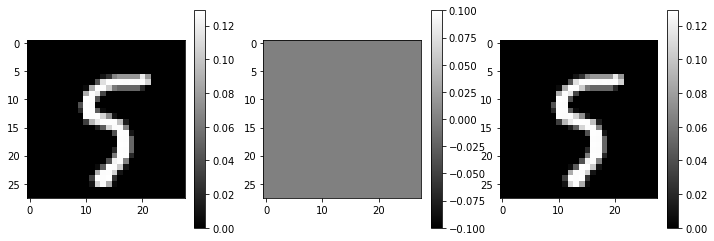

In [35]:
for i in range(10):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(x_test_pert[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    plt.colorbar()
    
    plt.show()

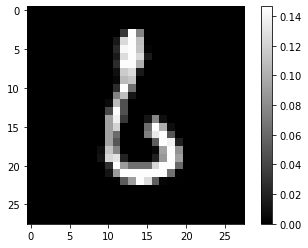

In [40]:
plt.imshow((x_test[0]).reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

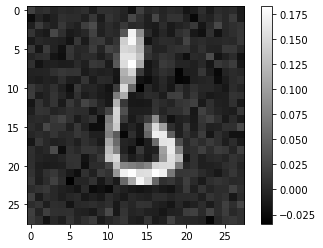

In [41]:
plt.imshow((x_test_adv[0]).reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

In [42]:
attack_samples = torch.tensor(scaler.transform(x_test_adv.squeeze())).float()

In [43]:
print('Validating...')
yhat = model(x_train)
yhat_test = model(x_test)
yhat_attack = model(attack_samples)

acc = (y_train == yhat).float().mean()
acc_test = (y_test == yhat_test).float().mean()
acc_attack = (y_test == yhat_attack).float().mean()

print(f'{acc = :6f}')
print(f'{acc_test = :6f}')
print(f'{acc_attack = :6f}')
print(f'{t = :6f}')

Validating...
acc = 0.945410
acc_test = 0.935429
acc_attack = 0.839714
t = 29.865211


In [20]:
import pickle

sample = {
    'data':attack_samples,
    'label':y_test
}

with open("HD_MNIST_DF.pickle", 'wb') as f:
    pickle.dump(sample, f)